# 데모

## 라이브러리 import 및 설정

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import lightgbm as lgb
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import warnings

In [4]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [5]:
data_dir = Path('./open')
feature_dir = Path('./open')
val_dir = Path('./open')
tst_dir = Path('./open')
sub_dir = Path('./open')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [6]:
algo_name = 'lgbcv'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [7]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [8]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


In [22]:
np.unique(y)

array([0., 1., 2.])

## Stratified K-Fold Cross Validation

In [9]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [27]:
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(i_trn)

[     0      3      4 ... 319995 319996 319997]
[     0      1      2 ... 319997 319998 319999]
[     1      2      3 ... 319997 319998 319999]
[     0      1      2 ... 319997 319998 319999]
[     0      1      2 ... 319996 319998 319999]


In [10]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = lgb.LGBMClassifier(objective='multiclass',
                             n_estimators=1000,
                             num_leaves=64,
                             learning_rate=0.1,
                             min_child_samples=10,
                             subsample=.5,
                             subsample_freq=1,
                             colsample_bytree=.8,
                             random_state=seed,
                             n_jobs=-1)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.860242
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.761506
[3]	valid_0's multi_logloss: 0.675522
[4]	valid_0's multi_logloss: 0.604616
[5]	valid_0's multi_logloss: 0.546706
[6]	valid_0's multi_logloss: 0.505077
[7]	valid_0's multi_logloss: 0.467878
[8]	valid_0's multi_logloss: 0.44
[9]	valid_0's multi_logloss: 0.411699
[10]	valid_0's multi_logloss: 0.382668
[11]	valid_0's multi_logloss: 0.358564
[12]	valid_0's multi_logloss: 0.337997
[13]	valid_0's multi_logloss: 0.319663
[14]	valid_0's multi_logloss: 0.303098
[15]	valid_0's multi_logloss: 0.289096
[16]	valid_0's multi_logloss: 0.276654
[17]	valid_0's multi_logloss: 0.266188
[18]	valid_0's multi_logloss: 0.256574
[19]	valid_0's multi_logloss: 0.2474
[20]	valid_0's multi_logloss: 0.240341
[21]	valid_0's multi_logloss: 0.23324
[22]	valid_0's multi_logloss: 0.226673
[23]	valid_0's multi_logloss: 0.220816
[24]	valid_0's multi_logloss: 0.2

[19]	valid_0's multi_logloss: 0.248893
[20]	valid_0's multi_logloss: 0.241775
[21]	valid_0's multi_logloss: 0.2344
[22]	valid_0's multi_logloss: 0.227824
[23]	valid_0's multi_logloss: 0.221976
[24]	valid_0's multi_logloss: 0.217773
[25]	valid_0's multi_logloss: 0.213611
[26]	valid_0's multi_logloss: 0.209973
[27]	valid_0's multi_logloss: 0.206087
[28]	valid_0's multi_logloss: 0.202424
[29]	valid_0's multi_logloss: 0.19929
[30]	valid_0's multi_logloss: 0.196741
[31]	valid_0's multi_logloss: 0.194161
[32]	valid_0's multi_logloss: 0.192034
[33]	valid_0's multi_logloss: 0.189676
[34]	valid_0's multi_logloss: 0.187624
[35]	valid_0's multi_logloss: 0.18574
[36]	valid_0's multi_logloss: 0.184367
[37]	valid_0's multi_logloss: 0.182946
[38]	valid_0's multi_logloss: 0.181529
[39]	valid_0's multi_logloss: 0.180416
[40]	valid_0's multi_logloss: 0.179091
[41]	valid_0's multi_logloss: 0.178011
[42]	valid_0's multi_logloss: 0.177042
[43]	valid_0's multi_logloss: 0.176054
[44]	valid_0's multi_logloss:

[151]	valid_0's multi_logloss: 0.164828
[152]	valid_0's multi_logloss: 0.164825
[153]	valid_0's multi_logloss: 0.164851
[154]	valid_0's multi_logloss: 0.164847
Early stopping, best iteration is:
[144]	valid_0's multi_logloss: 0.164706
training model for CV #4
[1]	valid_0's multi_logloss: 0.860254
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.761296
[3]	valid_0's multi_logloss: 0.675647
[4]	valid_0's multi_logloss: 0.605204
[5]	valid_0's multi_logloss: 0.547458
[6]	valid_0's multi_logloss: 0.505927
[7]	valid_0's multi_logloss: 0.468863
[8]	valid_0's multi_logloss: 0.441068
[9]	valid_0's multi_logloss: 0.412875
[10]	valid_0's multi_logloss: 0.384318
[11]	valid_0's multi_logloss: 0.360157
[12]	valid_0's multi_logloss: 0.339546
[13]	valid_0's multi_logloss: 0.321495
[14]	valid_0's multi_logloss: 0.304945
[15]	valid_0's multi_logloss: 0.290362
[16]	valid_0's multi_logloss: 0.278071
[17]	valid_0's multi_logloss: 0.267658
[18]	valid_0's multi_logl

[29]	valid_0's multi_logloss: 0.199344
[30]	valid_0's multi_logloss: 0.196882
[31]	valid_0's multi_logloss: 0.194116
[32]	valid_0's multi_logloss: 0.192051
[33]	valid_0's multi_logloss: 0.189758
[34]	valid_0's multi_logloss: 0.18759
[35]	valid_0's multi_logloss: 0.18577
[36]	valid_0's multi_logloss: 0.184422
[37]	valid_0's multi_logloss: 0.18305
[38]	valid_0's multi_logloss: 0.1816
[39]	valid_0's multi_logloss: 0.180666
[40]	valid_0's multi_logloss: 0.179399
[41]	valid_0's multi_logloss: 0.178278
[42]	valid_0's multi_logloss: 0.177493
[43]	valid_0's multi_logloss: 0.17658
[44]	valid_0's multi_logloss: 0.175773
[45]	valid_0's multi_logloss: 0.175239
[46]	valid_0's multi_logloss: 0.174592
[47]	valid_0's multi_logloss: 0.173959
[48]	valid_0's multi_logloss: 0.173376
[49]	valid_0's multi_logloss: 0.172615
[50]	valid_0's multi_logloss: 0.172068
[51]	valid_0's multi_logloss: 0.17145
[52]	valid_0's multi_logloss: 0.171066
[53]	valid_0's multi_logloss: 0.1706
[54]	valid_0's multi_logloss: 0.17

In [11]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.1081%


In [12]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [13]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [24]:
p_tst

array([[8.11256448e-04, 2.50383475e-01, 7.48805268e-01],
       [9.99901286e-01, 4.72427339e-05, 5.14709713e-05],
       [7.22596018e-04, 1.08447170e-01, 8.90830234e-01],
       ...,
       [9.99929624e-01, 2.94696375e-05, 4.09067649e-05],
       [8.24197144e-04, 1.24000565e-01, 8.75175238e-01],
       [9.99934206e-01, 2.84627224e-05, 3.73314197e-05]])

## 피처 중요도 시각화

<AxesSubplot:ylabel='feature'>

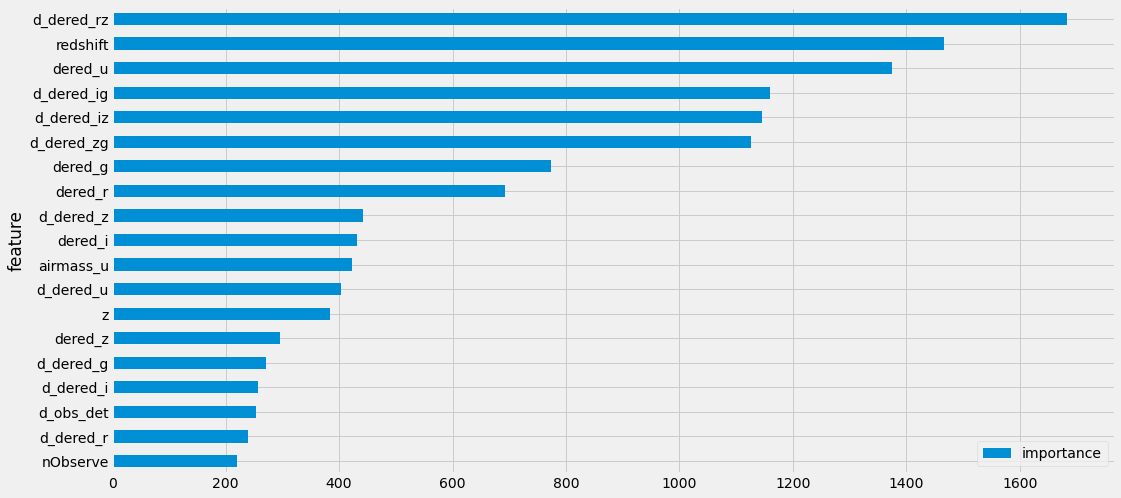

In [14]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [15]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [16]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [17]:
sub[target_col].value_counts()

2    41175
0    29974
1     8851
Name: class, dtype: int64

In [18]:
sub.to_csv(sub_file)

In [26]:
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2
